# Model Development and Apparent Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Using github PAT from envvar GITHUB_TOKEN. Use `gitcreds::gitcreds_set()` and unset GITHUB_TOKEN in .Renviron (or elsewhere) if you want to use the more secure git credential store instead.
Skipping install of 'calibrationHelper' from a github remote, the SHA1 (180c7c77) has not changed since last install.
  Use `force = TRUE` to force installation

# Penalized Likelihood Methods

## Backwards Stepwise Logistic Regression (obsolete)

In [ ]:
# library(StepReg)
# run_stepwise_logit <- function(data, formula) {
#   stepwise(
#     formula,
#     data = data,
#     type = "logit",
#     include = NULL,
#     strategy = "backward",
#     metric = "AIC"
#   )
# }

# stepwise_model <- data_patient_transformed |>
#   select(all_of(variables_to_screen_short), flag_ADR_TP_ID) |>
#   run_stepwise_logit(
#     formula = flag_ADR_TP_ID ~ .
#   )

# stepwise_model


In [ ]:
# run_step_AIC <- function(data, formula) {
#   MASS::stepAIC(
#     glm(
#       formula = formula,
#       data = data
#     ),
#     direction = "backward",
#     trace = FALSE
#   )
# }

# stepwise_model_MASS <- data_patient_transformed |>
#   select(all_of(predictor_transformed), flag_ADR_TP_ID) |>
#   run_step_AIC(
#     formula = flag_ADR_TP_ID ~ .
#   )

# stepwise_model_MASS |> str()


## LASSO Variable Selection (obsolete, see Elastic Net Regularization)

In [ ]:
# library(glmnet)
# predictor_matrix <- data_patient_complete |>
#   select(all_of(predictor_list)) |>
#   as.matrix()
# response_matrix <- data_patient_complete |>
#   select(flag_ADR_TP_ID) |>
#   pull()

# lasso_fit <- glmnet(
#   x = predictor_matrix,
#   y = response_matrix,
#   family = "binomial",
#   alpha = 1
# )

# cv_lasso_fit <- cv.glmnet(
#   x = predictor_matrix,
#   y = response_matrix,
#   family = "binomial",
#   alpha = 1,
#   nfolds = 5
# )

# coef(lasso_fit, s = cv_lasso_fit$lambda.min)@i |> length() - 1


In [ ]:
library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

## Elastic Net Regularization

In [ ]:
library(calibrationHelper)

rec <- recipe(flag_ADR_TP_ID ~ ., data = data_patient_screen) |>
  step_rm(patient_sex) |> # check for model fairness, not used in the model
  step_dummy(all_nominal_predictors())

model_elastic <- logistic_reg(penalty = tune(), mixture = tune()) |>
  set_engine("glmnet") |>
  set_mode("classification")

model_workflow <- workflow() |>
  add_model(model_elastic) |>
  add_recipe(rec)

tune_params <- model_workflow |>
  extract_parameter_set_dials() |>
  update(
    penalty = penalty(range = c(-3, 0)),
    mixture = mixture(range = c(0.5, 1))
  ) |>
  grid_latin_hypercube(size = 1000)

tic()
plan(multisession, workers = max(min(parallel::detectCores() - 1, 15), 2))

model_tune_results <- model_workflow |>
  tune_grid(
    resamples = cross_samples,
    grid = tune_params,
    control = control_grid(save_pred = TRUE, pkgs = "calibrationHelper"),
    metrics = metric_set(mcc, roc_auc, brier_class, cal_intercept, cal_slope)
  )

plan(sequential)
toc() # 210s


359.621 sec elapsed

# A tibble: 5 × 6
  .metric       .estimator    mean     n std_err .config             
  <chr>         <chr>        <dbl> <int>   <dbl> <chr>               
1 brier_class   binary      0.174      6  0.0130 Preprocessor1_Model1
2 cal_intercept binary     -0.0377     6  0.167  Preprocessor1_Model1
3 cal_slope     binary      1.08       6  0.142  Preprocessor1_Model1
4 mcc           binary      0.367      6  0.0477 Preprocessor1_Model1
5 roc_auc       binary      0.785      6  0.0194 Preprocessor1_Model1

# A tibble: 11 × 3
   term                   estimate penalty
   <chr>                     <dbl>   <dbl>
 1 (Intercept)            -0.712   0.00160
 2 baseline_CLCR          -0.00575 0.00160
 3 baseline_PLT           -0.00793 0.00160
 4 patient_age             0.0163  0.00160
 5 LZD_duration_14_TRUE.   0.962   0.00160
 6 comed_heparin_TRUE.     0.823   0.00160
 7 comed_enoxaparin_TRUE.  0.146   0.00160
 8 infect_sepsis_TRUE.     0.576   0.00160
 9 comorb_cirr_TRUE.       0.847   0.00160
10 invasive_CRRT_TRUE.     0.394   0.00160
11 dept_ICU_ER_TRUE.       0.0591  0.00160

In [ ]:
# model_workflow |>
#   finalize_workflow(model_accepted_flow) |>
#   fit_resamples(
#     resamples = cross_samples_grouped,
#     control = control_resamples(save_pred = TRUE)
#   ) |>
#   collect_predictions() |>
#   mutate(patient_age_group = data_patient_transformed$patient_age_group) |>
#   group_by(patient_age_group) |>
#   roc_auc(flag_ADR_TP_ID, .pred_TRUE, event_level = "second")


In [ ]:
# multi_glmnet <- model_glmnet |>
#   tidy() |>
#   filter(estimate > 0) |>
#   pull(term) |>
#   str_extract(paste(variables_to_screen, collapse = "|"))

# model_glmnet_fit <-
#   logistic_reg(
#     penalty = model_accepted_flow$penalty,
#     mixture = model_accepted_flow$mixture
#   ) |>
#   set_engine("glmnet") |>
#   fit(
#     flag_ADR_TP_ID ~ .,
#     data = data_patient_screen
#   ) |>
#   tidy()


In [ ]:
save(model_glmnet, file = "data/model-performance/model-glmnet.rda")


# Bayesian Methods

## Bayesian Model Selection

In [ ]:
data_patient_screen_full <- data_patient_transformed |>
  mutate(
    across(where(is.logical), as.factor)
  )


### Strategy 1-A: Screen “consensus” variables, continuous variables only (10 parameters)

0.379 sec elapsed

                     P(B != 0 | Y)      model 1      model 2   model 3
Intercept                1.0000000    1.0000000    1.0000000    1.0000
LZD_duration_14TRUE      0.9999541    1.0000000    1.0000000    1.0000
comed_heparinTRUE        0.9996539    1.0000000    1.0000000    1.0000
comed_enoxaparinTRUE     0.2743763    0.0000000    0.0000000    0.0000
infect_sepsisTRUE        0.8866863    1.0000000    1.0000000    1.0000
baseline_CLCR            0.6677624    1.0000000    1.0000000    0.0000
comorb_cirrTRUE          0.7462128    1.0000000    1.0000000    1.0000
invasive_CRRTTRUE        0.5017532    0.0000000    1.0000000    0.0000
dept_ICU_ERTRUE          0.2587005    0.0000000    0.0000000    0.0000
baseline_PLT             1.0000000    1.0000000    1.0000000    1.0000
patient_age              0.9528797    1.0000000    1.0000000    1.0000
BF                              NA    0.7039779    0.2565132    1.0000
PostProbs                       NA    0.0993000    0.0965000    0.0806
R2    

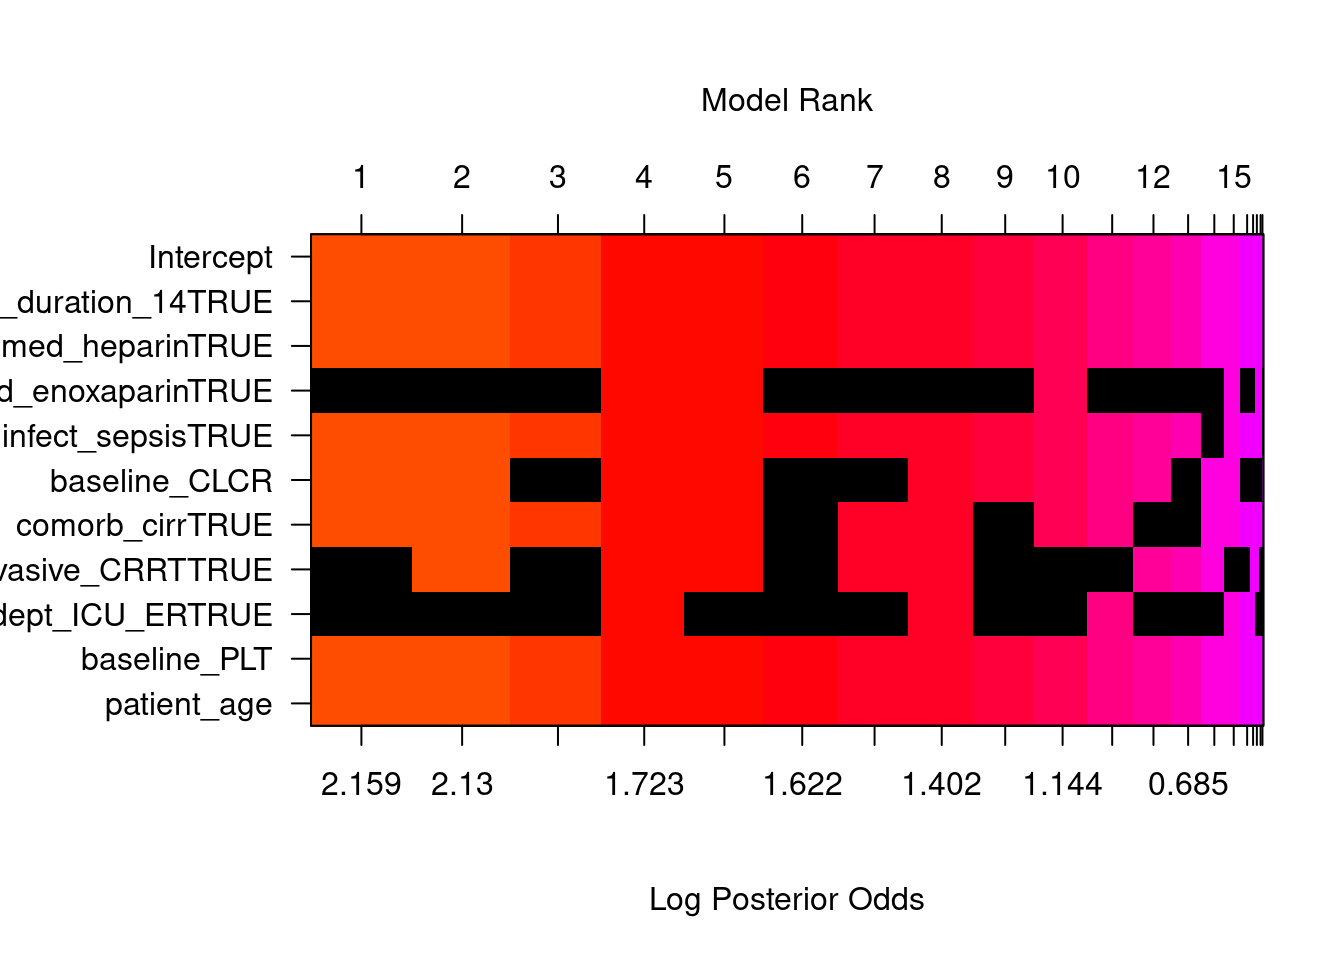

In [ ]:
# multi_model <- data_patient_complete |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   run_bas_glm(
#     formula = flag_ADR_TP_ID ~ .,
#     include.always = ~1
#   )

# summary(multi_model)
# plot(multi_model)
# image(multi_model, rotate = FALSE)
# diagnostics(multi_model)

library(tictoc)

tic()
multi_model_1_A <- data_patient_transformed |>
  select(all_of(variables_to_screen_short), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = ~1,
    n.models = 2^15,
    thin = length(variables_to_screen_short),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()


In [ ]:
library(tidymodels)
# library(probably)

model_basic_flow_1_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_A)) |>
  add_model(logistic_reg())

# model_full <- model_basic_flow |>
#   update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_HPM)) |>
#   fit(data = data_patient_screen)

model_full_BPM_1_A <- model_basic_flow_1_A |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_A)) |>
  fit(data = data_patient_screen_full)

# model_basic_performances <- workflow() |>
#   add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM)) |>
#   add_model(logistic_reg()) |>
#   fit_resamples(
#     resamples = cross_samples,
#     metrics = metric_set(roc_auc, brier_class, cal_intercept, cal_slope, sens, spec, ppv, npv),
#     control = control_resamples(save_pred = TRUE)
#   )

# model_basic_performances |>
#   collect_metrics()

# model_basic_performances |>
#   collect_predictions() |>
#   threshold_perf(flag_ADR_TP_ID, .pred_TRUE, thresholds = seq(0.1, 0.9, by = 0.1))

save(model_full_BPM_1_A, file = "data/model-performance/model-full-BPM-1-A.rda")


### Strategy 1-B: Force top 5, screen “consensus”, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_1_B <- data_patient_transformed |>
  select(all_of(variables_to_screen_short), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force),
    n.models = 2^15,
    thin = length(variables_to_screen_short),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()


0.026 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_1_B <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_B)) |>
  add_model(logistic_reg())

model_full_BPM_1_B <- model_basic_flow_1_B |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_B)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_1_B, file = "data/model-performance/model-full-BPM-1-B.rda")


### Strategy 1-C: Force top 5 (allow categorical), screen “consensus”, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_1_C <- data_patient_transformed |>
  select(all_of(variables_to_screen_short_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_binary),
    n.models = 2^15,
    thin = length(variables_to_screen_short_binary),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()


0.024 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_1_C <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_C)) |>
  add_model(logistic_reg())

model_full_BPM_1_C <- model_basic_flow_1_C |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_C)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_1_C, file = "data/model-performance/model-full-BPM-1-C.rda")


### Strategy 1-D: Force top 3, screen “consensus”, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_1_D <- data_patient_transformed |>
  select(all_of(variables_to_screen_short_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_top_3),
    n.models = 2^15,
    thin = length(variables_to_screen_short_binary),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()


0.056 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_1_D <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_D)) |>
  add_model(logistic_reg())

model_full_BPM_1_D <- model_basic_flow_1_D |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_D)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_1_D, file = "data/model-performance/model-full-BPM-1-D.rda")


### Strategy 2-A: Screen top 21 (by mean), continuous only

102.942 sec elapsed

                      P(B != 0 | Y)      model 1   model 2       model 3
Intercept                1.00000000    1.0000000    1.0000    1.00000000
LZD_duration_14TRUE      0.99984098    1.0000000    1.0000    1.00000000
comed_heparinTRUE        0.99972168    1.0000000    1.0000    1.00000000
comed_enoxaparinTRUE     0.05303465    0.0000000    0.0000    0.00000000
infect_sepsisTRUE        0.72451934    1.0000000    1.0000    0.00000000
baseline_CLCR            0.34313116    0.0000000    0.0000    0.00000000
comorb_cirrTRUE          0.38935686    0.0000000    1.0000    0.00000000
invasive_CRRTTRUE        0.20678417    0.0000000    0.0000    0.00000000
dept_ICU_ERTRUE          0.06252717    0.0000000    0.0000    0.00000000
baseline_PLT             1.00000000    1.0000000    1.0000    1.00000000
patient_age              0.92847896    1.0000000    1.0000    1.00000000
LZD_route_IVTRUE         0.04675567    0.0000000    0.0000    0.00000000
infect_septicemiaTRUE    0.08878479    0.0000000   

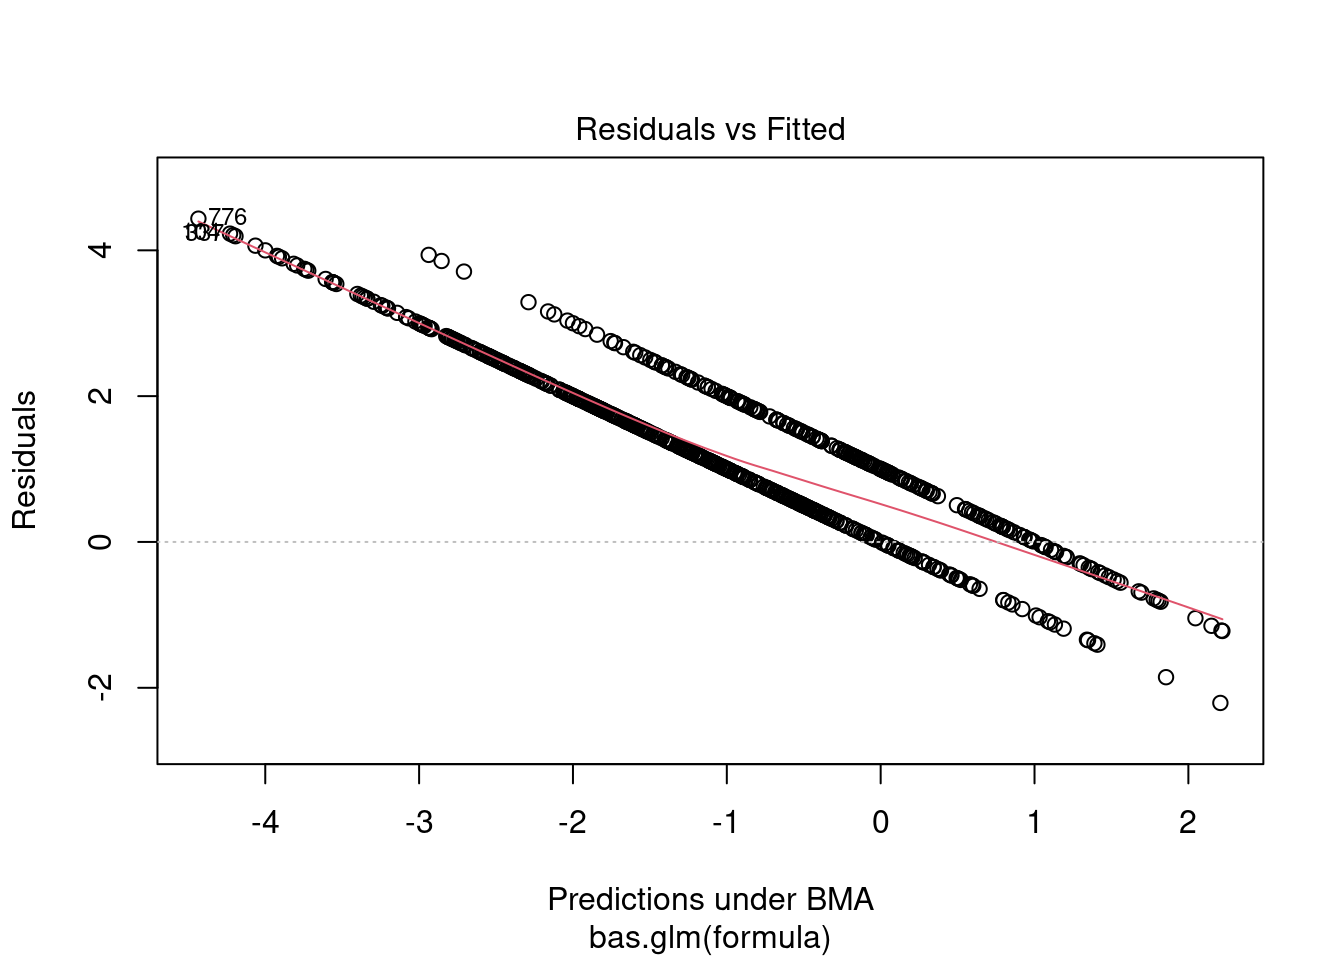

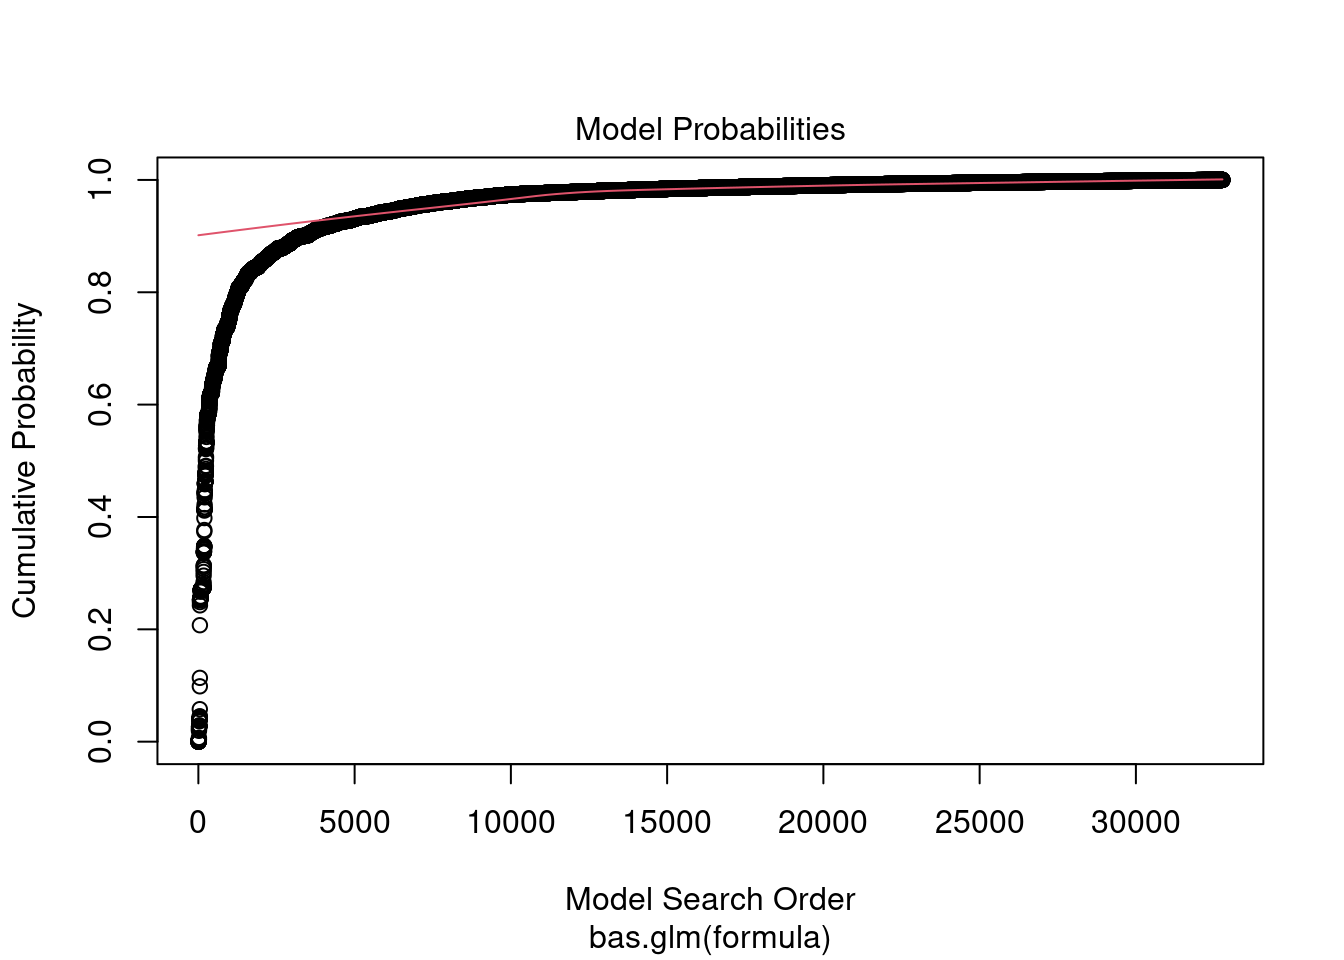

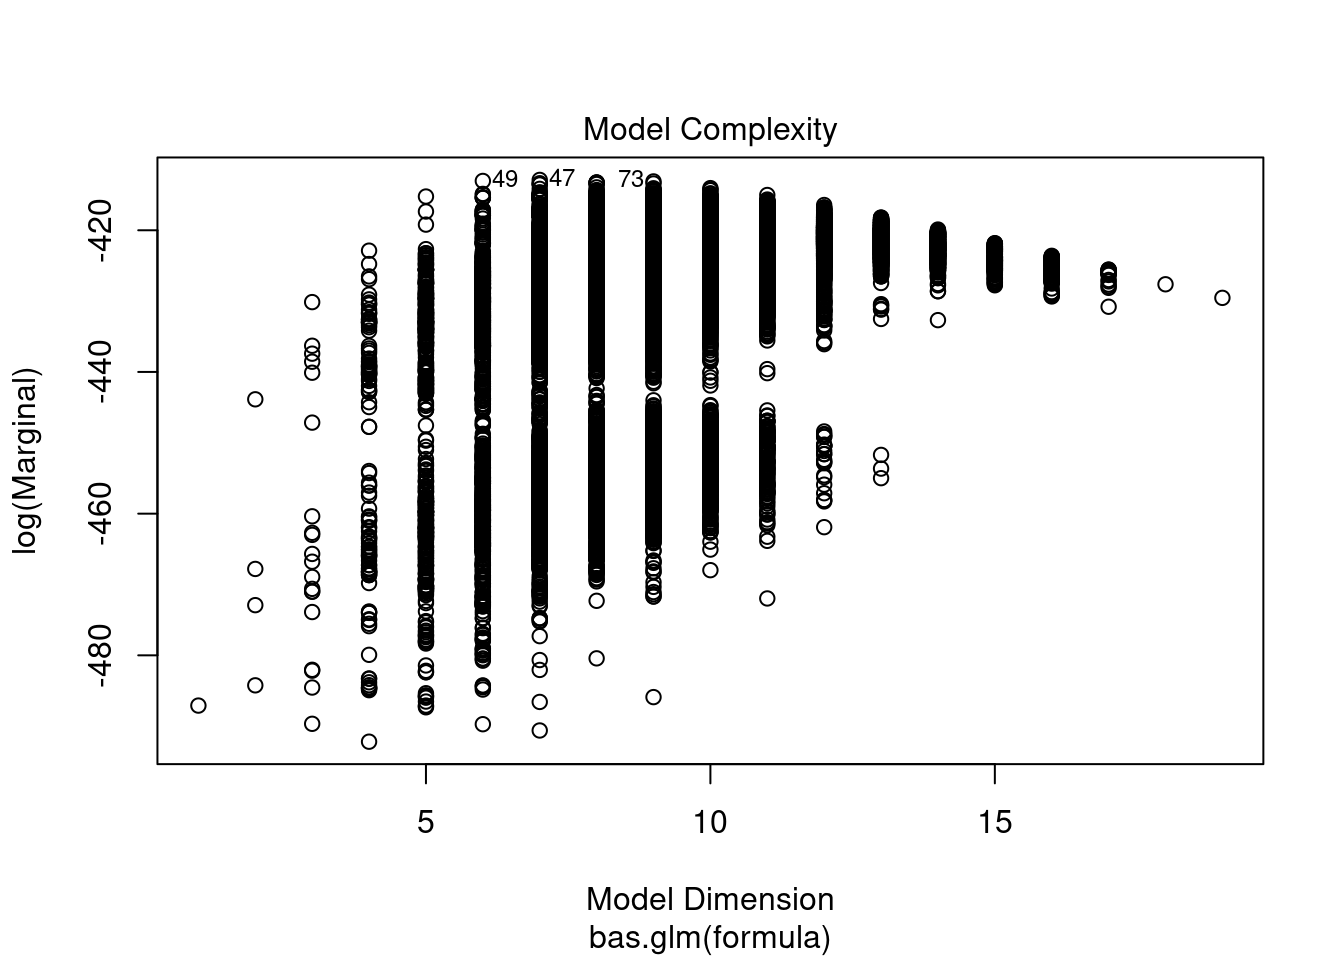

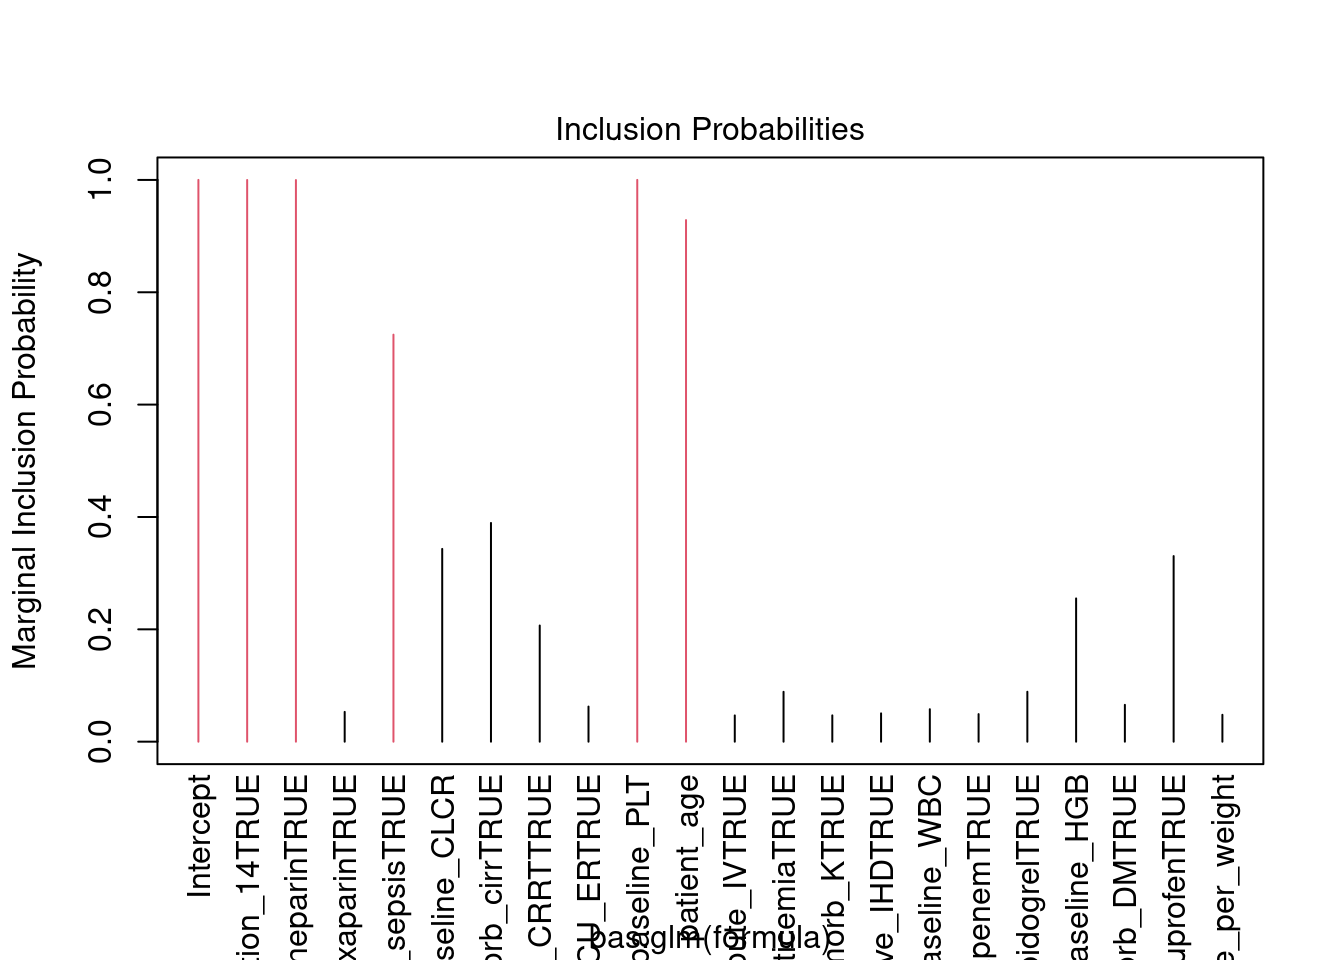

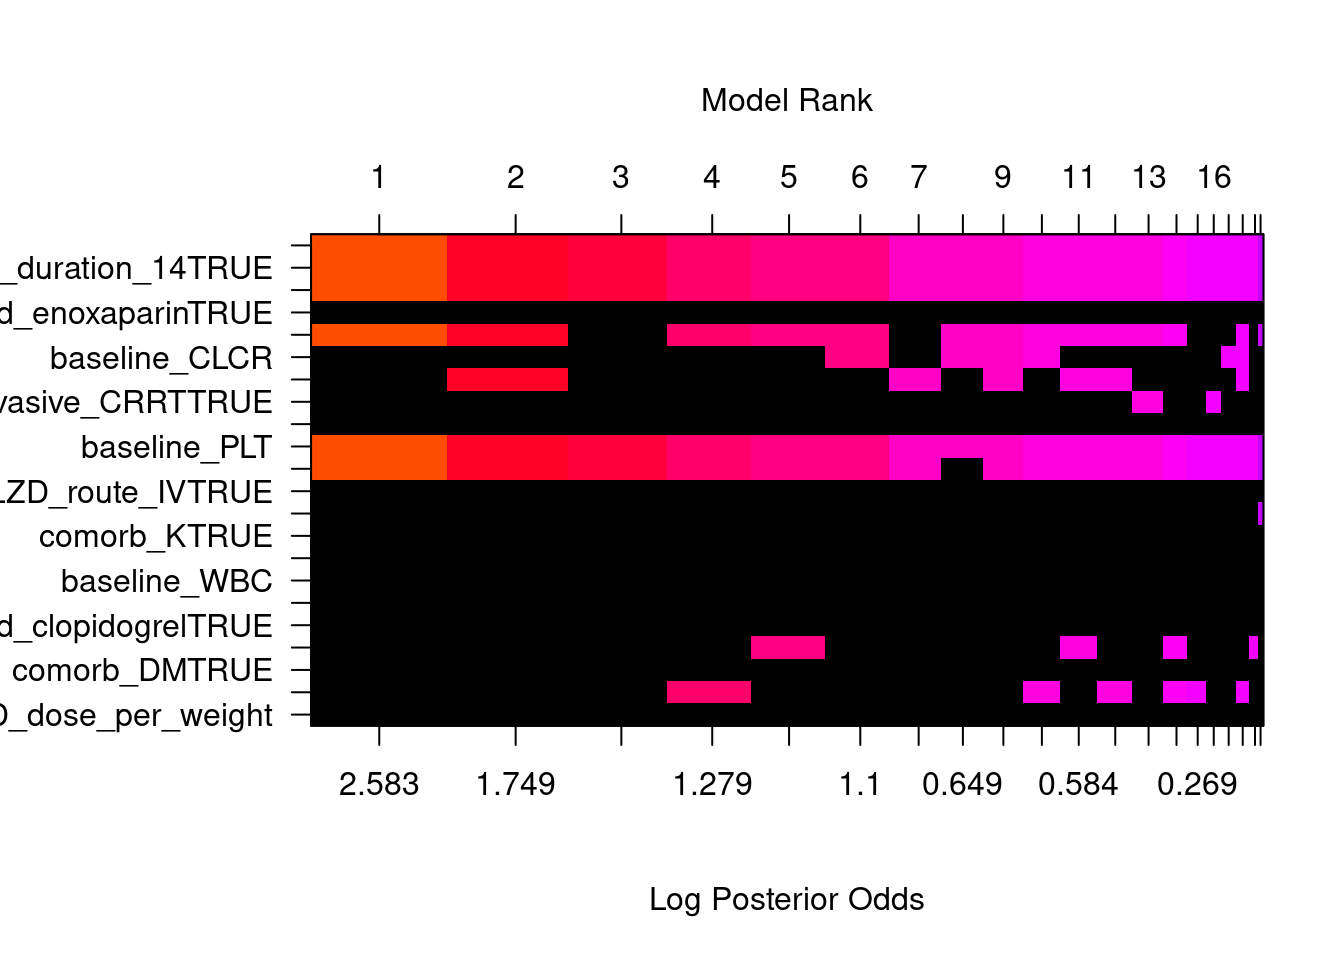

In [ ]:
library(tictoc)

tic()
multi_model_2_A <- data_patient_transformed |>
  select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = ~1,
    n.models = 2^15, # 150s ~ 90%, 300s ~ 95%
    thin = length(variables_to_screen),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()


In [ ]:
library(tidymodels)

model_basic_flow_2_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_A)) |>
  add_model(logistic_reg())

model_full_BPM_2_A <- model_basic_flow_2_A |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_A)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_A, file = "data/model-performance/model-full-BPM-2-A.rda")


### Strategy 2-B: Force top 5, screen top 21 (by mean), continuous only

In [ ]:
library(tictoc)

tic()
multi_model_2_B <- data_patient_transformed |>
  select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force),
    n.models = 2^15,
    thin = length(variables_to_screen),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()


86.409 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_2_B <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_B)) |>
  add_model(logistic_reg())

model_full_BPM_2_B <- model_basic_flow_2_B |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_B)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_B, file = "data/model-performance/model-full-BPM-2-B.rda")


### Strategy 2-C: Force top 5 (allow categorical), screen top 21 (by mean), continuous only

In [ ]:
library(tictoc)

tic()
multi_model_2_C <- data_patient_transformed |>
  select(all_of(variables_to_screen_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_binary),
    n.models = 2^15,
    thin = length(variables_to_screen_binary),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()


81.708 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_2_C <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_C)) |>
  add_model(logistic_reg())

model_full_BPM_2_C <- model_basic_flow_2_C |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_C)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_C, file = "data/model-performance/model-full-BPM-2-C.rda")


### Strategy 2-D: Force top 3, screen top 21 (by mean), continuous only

In [ ]:
library(tictoc)

tic()
multi_model_2_D <- data_patient_transformed |>
  select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_top_3),
    n.models = 2^15,
    thin = length(variables_to_screen),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()


87.806 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_2_D <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_D)) |>
  add_model(logistic_reg())

model_full_BPM_2_D <- model_basic_flow_2_D |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_D)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_D, file = "data/model-performance/model-full-BPM-2-D.rda")


### Strategy 3-A: Screen all, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_3_A <- data_patient_transformed |>
  select(any_of(variables_to_screen_all), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = ~1,
    n.models = 2^16, # 900s, 65%
    thin = length(variables_to_screen_all),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^11
  )
toc()


534.949 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_3_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_A)) |>
  add_model(logistic_reg())

model_full_BPM_3_A <- model_basic_flow_3_A |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_A)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_A, file = "data/model-performance/model-full-BPM-3-A.rda")


### Strategy 3-B: Force top 5, screen all, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_3_B <- data_patient_transformed |>
  select(any_of(variables_to_screen_all), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force),
    n.models = 2^15, # 300s
    thin = length(variables_to_screen_all),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()


168.579 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_3_B <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_B)) |>
  add_model(logistic_reg())

model_full_BPM_3_B <- model_basic_flow_3_B |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_B)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_B, file = "data/model-performance/model-full-BPM-3-B.rda")


### Strategy 3-C: Force top 5 (allow categorical), screen all, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_3_C <- data_patient_transformed |>
  select(any_of(variables_to_screen_all_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_binary),
    n.models = 2^15, # 300s
    thin = length(variables_to_screen_all_binary),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()


215.636 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_3_C <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_C)) |>
  add_model(logistic_reg())

model_full_BPM_3_C <- model_basic_flow_3_C |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_C)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_C, file = "data/model-performance/model-full-BPM-3-C.rda")


### Strategy 3-D: Force top 3, screen all, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_3_D <- data_patient_transformed |>
  select(any_of(variables_to_screen_all), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_top_3),
    n.models = 2^15, # 350s
    thin = length(variables_to_screen_all),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()


235.241 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_3_D <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_D)) |>
  add_model(logistic_reg())

model_full_BPM_3_D <- model_basic_flow_3_D |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_D)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_D, file = "data/model-performance/model-full-BPM-3-D.rda")


### Summary

In [ ]:
strategy_combos <- expand_grid(numbers = 1:3, chars = LETTERS[1:4])

model_file_list <- paste0(
  "data/model-performance/model-full-BPM-", 
  strategy_combos$numbers, "-", strategy_combos$chars, ".rda"
)

for (i in seq_along(model_file_list)) {
  model_file_list[i] |> load()
}


In [ ]:
library(tidymodels)

strategy_combos_vec <- paste0(
  strategy_combos$numbers, "_", strategy_combos$chars
)

model_strategy_list <- paste0(
  "model_full_BPM_", strategy_combos_vec
) |> mget()

retrieve_terms <- function(model) {
  model |>
    tidy() |>
    filter(term != "(Intercept)") |>
    pull(term) |>
    str_remove("TRUE")
}

max_length <- map(model_strategy_list, retrieve_terms) |>
  map_int(length) |>
  max()

term_summary <- map(model_strategy_list, retrieve_terms) |>
  map(~ `length<-`(.x, max_length)) |>
  as_tibble()

retrieve_estimates <- function(model, combo_vec) {
  model |>
    tidy() |>
    select(term, estimate) |>
    rename_with(
      ~ paste0(
        "", combo_vec,
        recycle0 = TRUE
      ),
      .cols = estimate
    ) |>
    mutate(term = str_remove(term, "TRUE"))
}

model_summary_list <- map2(
  model_strategy_list,
  strategy_combos_vec,
  retrieve_estimates
)

model_summary_template <- map(model_strategy_list, retrieve_terms) |>
  unlist(use.names = FALSE) |>
  unique() |>
  as_tibble() |>
  rename(term = value)

bind_estimates <- function(model_summary, model_summary_template) {
  model_summary |>
    full_join(model_summary_template, by = "term")
}

model_summary <- model_summary_list |>
  reduce(bind_estimates) |>
  mutate(across(where(is.numeric), ~ case_match(
    term,
    "baseline_CLCR" ~ . * 30,
    "baseline_PLT" ~ . * 25,
    "patient_age" ~ . * 10,
    .default = .
  ))) |>
  mutate(across(where(is.numeric), ~ exp(.) |> round(3))) |>
  mutate(term = case_match(
    term,
    "baseline_CLCR" ~ "baseline_CLCR_per_30",
    "baseline_PLT" ~ "baseline_PLT_per_25",
    "patient_age" ~ "patient_age_per_10",
    .default = term
  ))


``` r
model_summary |> knitr::kable()
```

  ----------------------------------------------------------------------------------------------------------------------
  term                       1_A     1_B     1_C     1_D     2_A     2_B     2_C     2_D     3_A     3_B     3_C     3_D
  ---------------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
  (Intercept)              0.482   0.525   0.291   0.275   0.358   1.920   0.381   0.357   0.274   1.920   0.997   0.274

  LZD_duration_14          2.681   2.704   2.723   2.689   2.688   2.644   2.772   2.688   2.682   2.644   2.605   2.682

  comed_heparin            2.405   2.608   2.464   2.249   2.770   2.376   2.474   2.768   2.714   2.376   2.237   2.714

  infect_sepsis            1.811   1.938   1.937   1.829   2.052   2.073   1.999   2.052      NA   2.073   2.141      NA

  baseline_CLCR_per_30     0.853   0.836      NA      NA      NA   0.770      NA      NA      NA   0.770      NA      NA

  comorb_cirr              2.280   2.401   2.578   2.564      NA      NA      NA      NA      NA      NA      NA      NA

  invasive_CRRT            1.507      NA      NA   1.403      NA      NA      NA      NA      NA      NA      NA      NA

  baseline_PLT_per_25      0.817   0.814   0.811   0.813   0.801   0.811   0.800   0.801   0.802   0.811   0.805   0.802

  patient_age_per_10       1.198   1.183   1.199   1.204   1.247      NA   1.191   1.247   1.268      NA      NA   1.268

  comed_enoxaparin            NA   1.191   1.213   1.205      NA   1.212   1.113   1.005   0.877   1.212   1.206   0.877

  baseline_CLCR_30            NA      NA   1.822   1.772      NA      NA   1.717      NA      NA      NA   2.061      NA

  invasive_CVC                NA      NA      NA      NA      NA      NA      NA      NA   1.855      NA      NA   1.855
  ----------------------------------------------------------------------------------------------------------------------

## Model Performance (completed in notebook 04, this will be removed)

In [ ]:
# library(CalibrationCurves)
# pHat <- predict(model_full_BPM$fit$fit$fit, data_patient_screen, type = "response")
# yTest <- data_patient_screen$flag_ADR_TP_ID |> as.logical()
# calperf <- valProbggplot(pHat, yTest)

# apparent_performance_metrics <- tibble(
#   cross_C_index = calperf$Cindex[[1]],
#   cross_C_index_lower = calperf$Cindex[[2]],
#   cross_C_index_upper = calperf$Cindex[[3]],
#   cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
#   cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
#   cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
#   cross_calibration_slope = calperf$Calibration$Slope[[1]],
#   cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
#   cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
# ) |>
#   mutate(
#     cross_C_index_std_error = (cross_C_index_upper - cross_C_index_lower) / (2 * 1.96),
#     cross_calibration_intercept_std_error = (cross_calibration_intercept_upper - cross_calibration_intercept_lower) / (2 * 1.96),
#     cross_calibration_slope_std_error = (cross_calibration_slope_upper - cross_calibration_slope_lower) / (2 * 1.96)
#   ) |>
#   select(
#     cross_calibration_intercept, cross_calibration_intercept_std_error, cross_calibration_slope, cross_calibration_slope_std_error
#   ) |>
#   rename(
#     cal_in_the_large = cross_calibration_intercept, 
#     cal_in_the_large_std_error = cross_calibration_intercept_std_error, 
#     cal_slope = cross_calibration_slope, 
#     cal_slope_std_error = cross_calibration_slope_std_error) |>
#   pivot_longer(
#     cols = everything(),
#     names_to = c(".metric"),
#     values_to = c("mean")
#   ) |>
#   mutate(std_err = if_else(str_detect(.metric, "std_error"), mean, lead(mean))) |>
#   filter(!str_detect(.metric, "std_error")) |>
#   bind_rows(model_basic_performances |> collect_metrics())

# save(apparent_performance_metrics, file = "data/model-performance/apparent-performance-metrics.rda")


In [ ]:
# pHat <- predict(model_full_BPM$fit, data_patient_transformed, type = "response")
# yTest <- data_patient_transformed$flag_ADR_TP_ID
# calperf <- valProbggplot(pHat, yTest)

# apparent_performance_metrics_BPM <- tibble(
#   apparent_C_index = calperf$Cindex[[1]],
#   apparent_calibration_intercept = calperf$Calibration$Intercept[[1]],
#   apparent_calibration_slope = calperf$Calibration$Slope[[1]]
# )

# save(apparent_performance_metrics_BPM, file = "data/model-performance/apparent-performance-metrics-BPM.rda")


## Bayesian Generalized Additive Model (WIP)

In [ ]:
# library(spikeSlabGAM)
# run_spike_slab_GAM <- function(data, formula, ...) {
#   spikeSlabGAM(formula, data = data, family = "binomial", ...)
# }

# data_model <- data_patient_transformed |>
#   select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
#   select(-c("baseline_CLCR_30", "baseline_CLCR_60", "LZD_duration_10", "baseline_PLT_150", "patient_age_65")) |>
#   as.data.frame()

# options(mc.cores = max(min(parallel::detectCores() - 1, 12), 2))

# model_0 <-
#   run_spike_slab_GAM(
#     data = data_model,
#     formula = reformulate(
#       termlabels = colnames(data_model) |> setdiff(c("flag_ADR_TP_ID")),
#       response = "flag_ADR_TP_ID"
#     )
#   )

# summary(model_0)
# plot(model_0)


## Nomogram with rms (WIP)

In [ ]:
# library(splines2)

# library(rms)

# data_patient_transformed |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   select_if(is.numeric) |>
#   map(quantile, probs = c(0, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1))

# dd <- data_patient_transformed |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   datadist()

# dd$limits$patient_age <- c(50, 62, 73, 19, 91, 19, 92)
# dd$limits$baseline_PLT <- c(143, 206, 288, 21, 433, 18, 434)
# dd$limits$baseline_CLCR <- c(21, 48, 84, 5, 184, 5, 189)
# dd$limits$LZD_duration <- c(6, 9, 14, 3, 26, 3, 28)

# options(datadist = "dd")
# nomo_obj <- lrm(flag_ADR_TP_ID ~ rcs(patient_age, 3) + rcs(baseline_PLT, 3) + rcs(baseline_CLCR, 3) + rcs(LZD_duration, 3) + invasive_CRRT + comed_heparin, data = data_patient_transformed) |>
#   nomogram(fun = plogis, funlabel = "Risk") |>
#   plot()

# for(k in 3:5) {
#   f <- lrm(flag_ADR_TP_ID ~ rcs(patient_age, k) + rcs(baseline_PLT, k) + rcs(baseline_CLCR, k) + rcs(LZD_duration, k) + invasive_CRRT * comed_heparin, data = data_patient_transformed)
#   cat('k=', k, '  AIC=', AIC(f), '\n')
# }

# print.nomogram <- function(x, dec = 0, ...) {
#   obj <- x
#   w <- diff(range(obj$lp$x)) / diff(range(obj$lp$x.real))
#   cat(
#     "Points per unit of linear predictor:", format(w),
#     "\nLinear predictor units per point   :", format(1 / w), "\n\n"
#   )

#   fun <- FALSE
#   for (x in names(obj)) {
#     k <- x == "total.points" || x == "lp" || x == "abbrev"
#     if (k) {
#       fun <- TRUE
#       next
#     }
#     y <- obj[[x]]
#     if (fun) {
#       z <- cbind(round(y[[1]], dec), y$x.real)
#       dimnames(z) <- list(rep("", nrow(z)), c("Total Points", x))
#     } else {
#       z <- cbind(format(y[[1]]), format(round(y$points, dec)))
#       dimnames(z) <- list(rep("", length(y$points)), c(x, "Points"))
#       ## didn't use data.frame since wanted blank row names
#     }
#     cat("\n")
#     print(z, quote = FALSE)
#     cat("\n")
#   }
#   invisible()
# }


# Check Model Assumptions

## Linearity

Visual check of linearity assumption using partial-residual plots (component+residual plots).

Blue dashed line: linear fit of the partial residuals.

Red line: smoothed conditional mean

The lines should be close together and the red line should be linear.

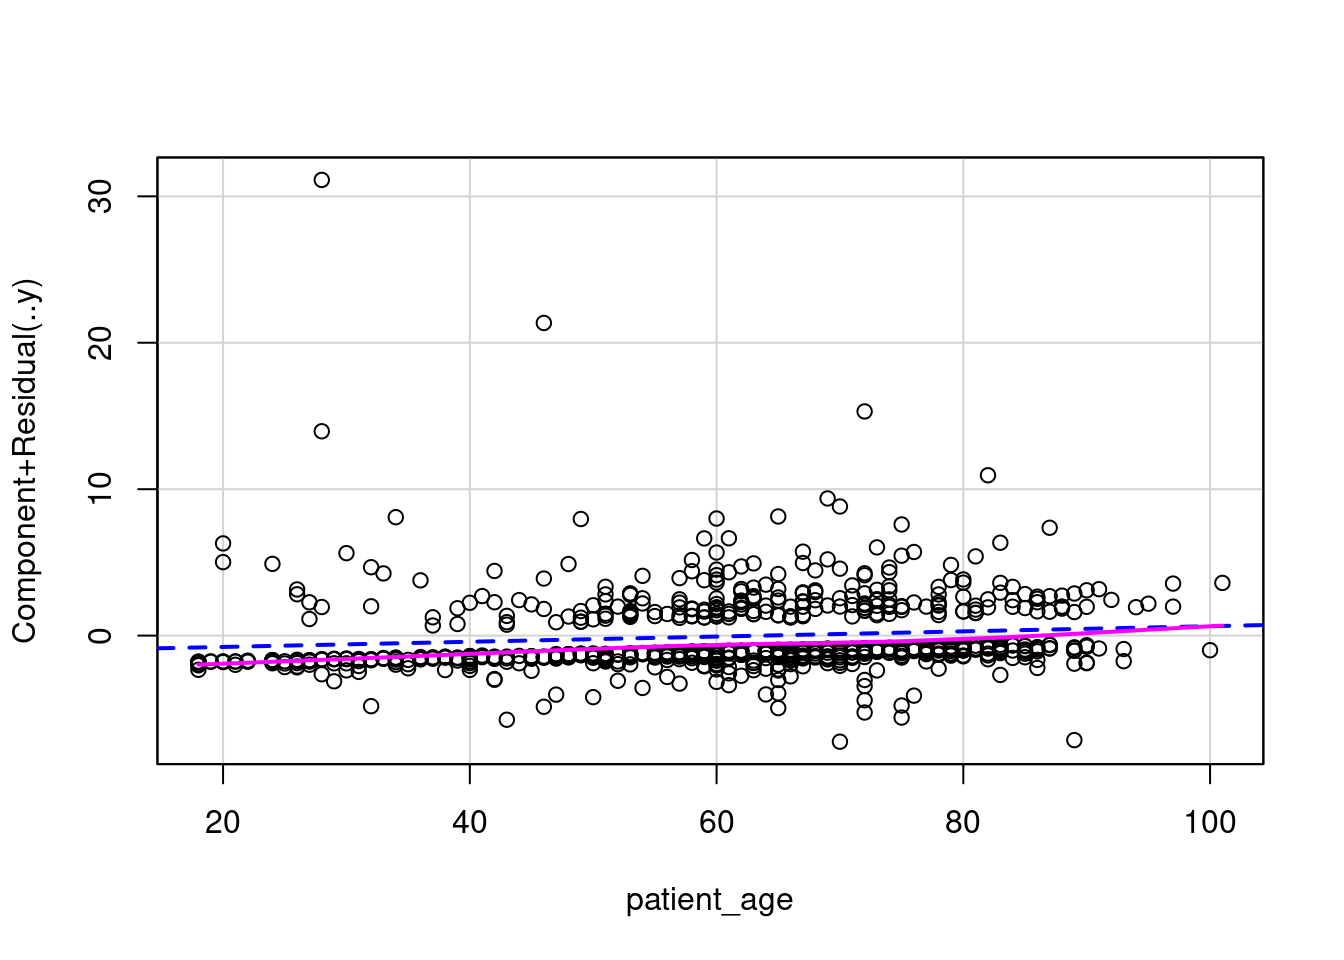

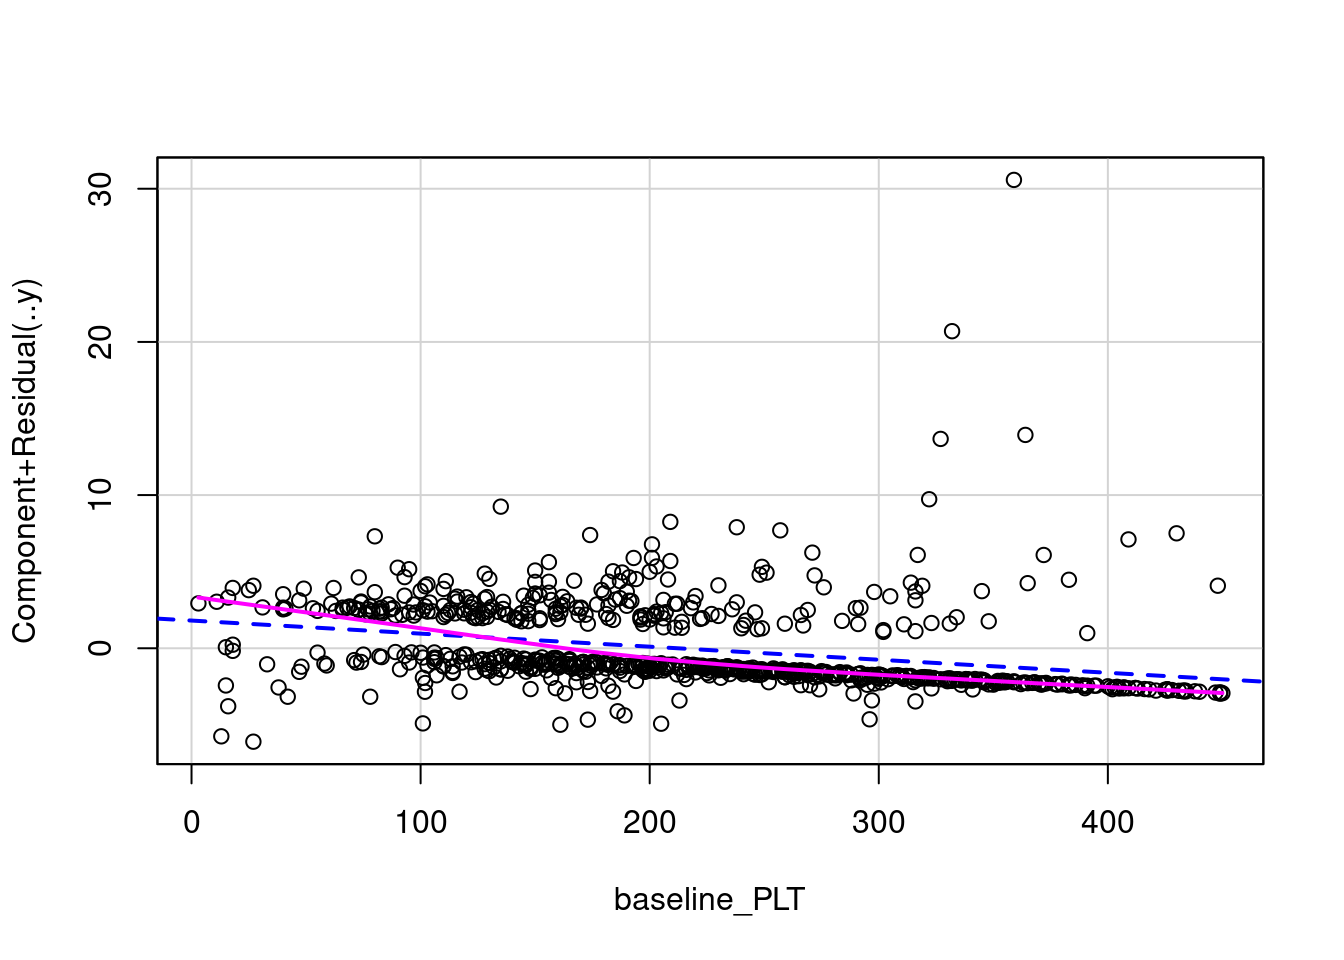

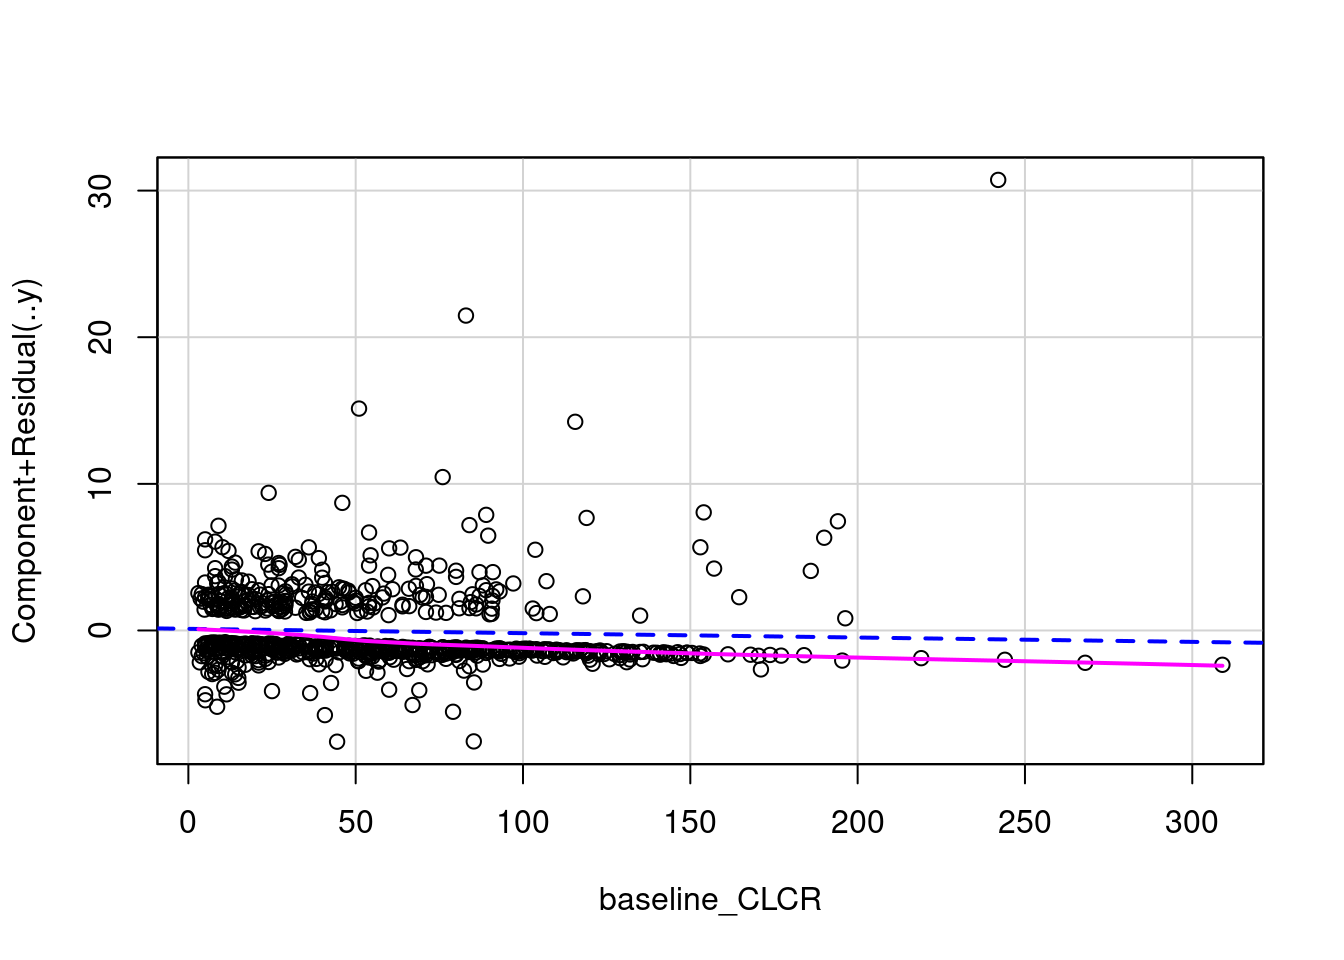

In [ ]:
# car::crPlot(model_full$fit, variable = "patient_age")
# car::crPlot(model_full$fit, variable = "baseline_PLT")

car::crPlot(model_full_BPM_1_A |> extract_fit_engine(), variable = "patient_age")


Result: No obvious non-linearity in the partial-residual plots.

Visual check of linearity assumption using logit of predicted probabilities vs. continuous predictors values.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

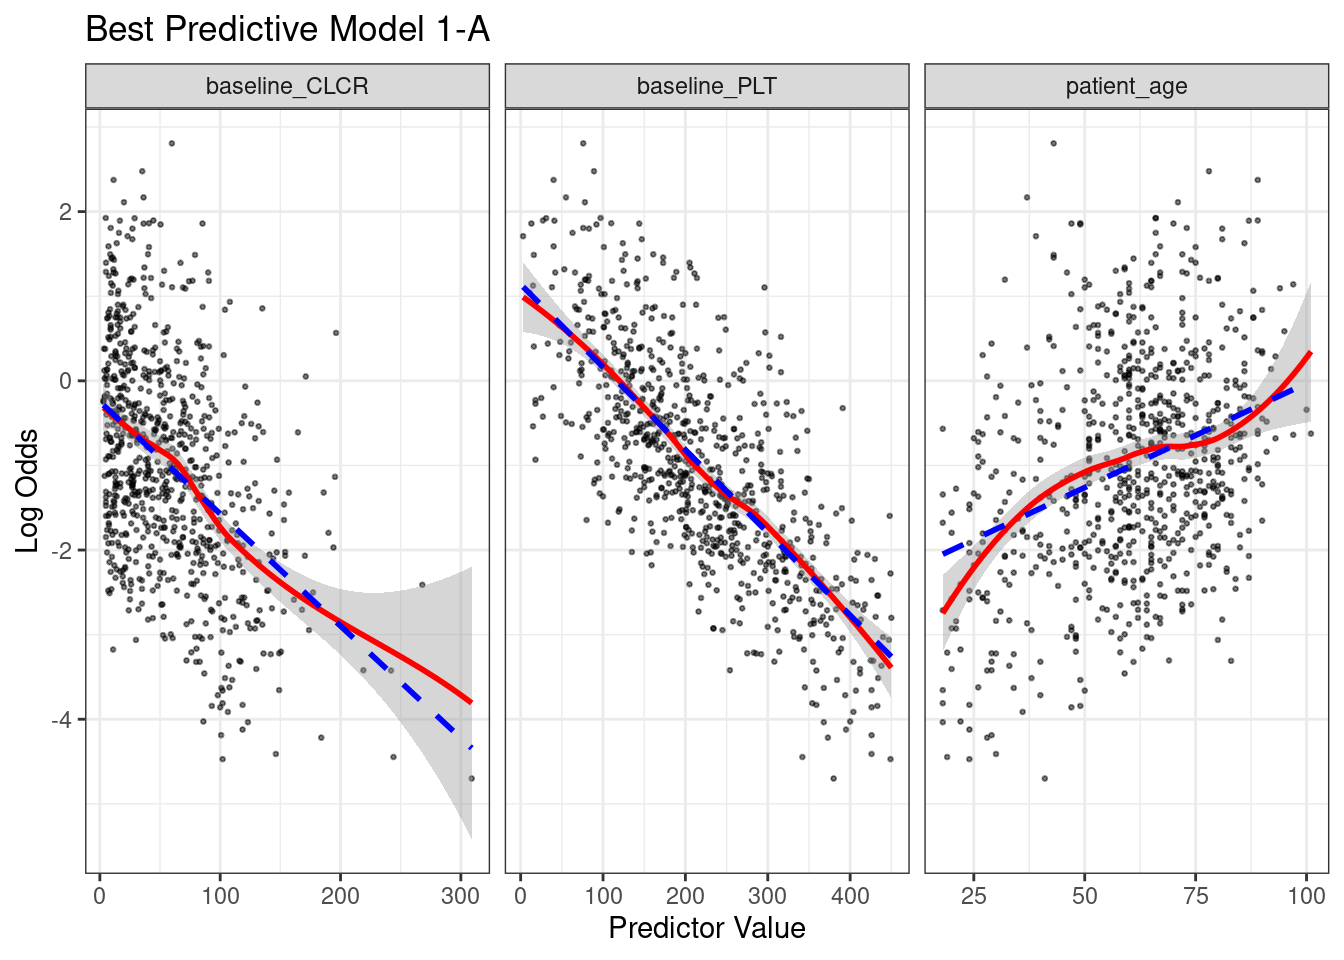

In [ ]:
# data_patient_linear_check <- data_patient_transformed |>
#   select(all_of(multi_predict_HPM)) |>
#   mutate(
#     probabilities = predict(model_full$fit, data_patient_transformed, type = "response"),
#     log_odds = log(probabilities / (1 - probabilities))
#   ) |>
#   select_if(is.numeric) |>
#   gather(key = "predictors", value = "predictor_value", -log_odds, -probabilities)

# ggplot(data_patient_linear_check, aes(y = log_odds, x = predictor_value)) +
#   geom_point(size = 0.5, alpha = 0.5) +
#   geom_smooth(method = "loess", color = "red") +
#   geom_smooth(method = "lm", linetype = "dashed", color = "blue", se = FALSE) +
#   theme_bw() +
#   facet_wrap(~predictors, scales = "free_x") +
#   labs(title = "Highest Probability Model", x = "Predictor Value", y = "Log Odds")

data_patient_linear_check_BPM <- data_patient_transformed |>
  select(all_of(multi_predict_BPM_1_A)) |>
  mutate(
    probabilities = predict(model_full_BPM_1_A |> extract_fit_engine(), data_patient_screen, type = "response"),
    log_odds = log(probabilities / (1 - probabilities))
  ) |>
  select_if(is.numeric) |>
  gather(key = "predictors", value = "predictor_value", -log_odds, -probabilities)

ggplot(data_patient_linear_check_BPM, aes(y = log_odds, x = predictor_value)) +
  geom_point(size = 0.5, alpha = 0.5) +
  geom_smooth(method = "loess", color = "red") +
  geom_smooth(method = "lm", linetype = "dashed", color = "blue", se = FALSE) +
  theme_bw() +
  facet_wrap(~predictors, scales = "free_x") +
  labs(title = "Best Predictive Model 1-A", x = "Predictor Value", y = "Log Odds")


## No Multicollinearity

VIFs from the coefficient estimates should be less than 5 and as close to 1 as possible.

In [ ]:
car::vif(model_full_BPM_1_A |> extract_fit_engine())


LZD_duration_14   comed_heparin   infect_sepsis   baseline_CLCR     comorb_cirr 
       1.080529        1.197127        1.081271        1.255067        1.047907 
  invasive_CRRT    baseline_PLT     patient_age 
       1.186486        1.106433        1.286819 

Result: VIFs are all less than 5 and close to 1.

## No Outlier Effects

Visual check from influence plot.

Individual observations should not have too much influence on the model.

Influence plot:

-   x-axis: Extreme values (Hat-values)
-   y-axis: Leverage (Studentized residuals)
-   Size of points: Cook’s distance

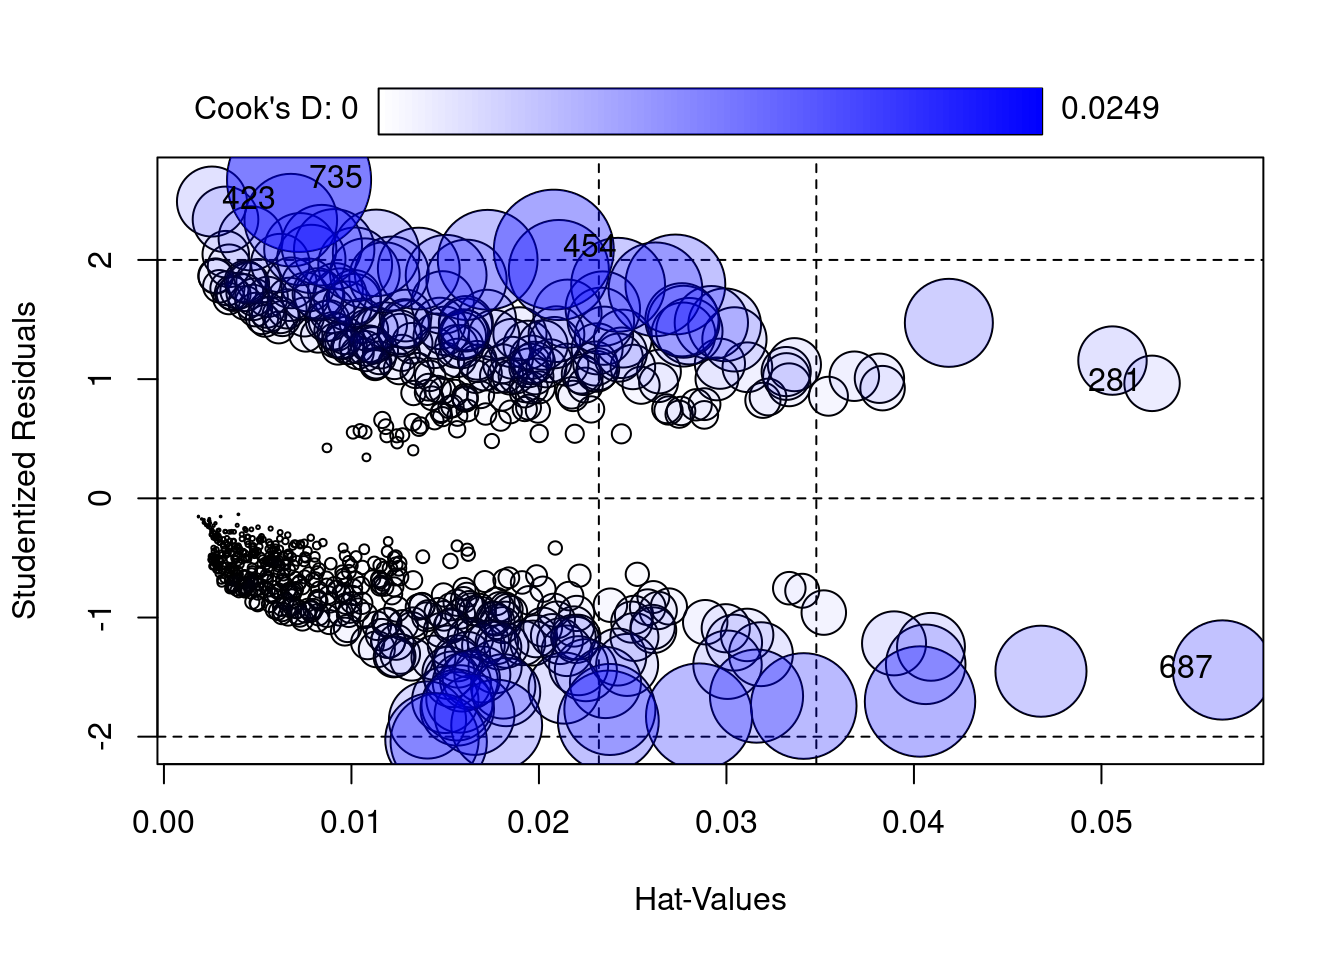

      StudRes         Hat       CookD
281  0.964544 0.052699255 0.003702058
423  2.489919 0.002561191 0.005896680
454  2.086504 0.020793226 0.017279030
687 -1.440257 0.056450873 0.011855282
735  2.671358 0.007206990 0.024949692

 [1]   6  14  79  99 119 144 148 208 213 251 281 312 325 332 349 364 423 460 545
[20] 598 642 653 687 716 735

In [ ]:
# car::influencePlot(model_full$fit)

car::influencePlot(model_full_BPM_1_A |> extract_fit_engine())


In [ ]:
# data_patient_transformed |>
#   slice(c(292, 301, 335, 364, 504, 634)) |> summary()


In [ ]:
# save(model_full, file = "data/model-performance/model-full.rda")
